In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysr
from sklearn.linear_model import LinearRegression
from scipy.integrate import solve_ivp

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [20]:
# Load the dataset
data = pd.read_csv("synthetic_data.csv")

# Display the first few rows
print("First few rows of the dataset:")
print(data.head())

# Merge A1 and A2 into a single column
A_combined = np.concatenate((data["A1"].values, data["A2"].values))
time_combined = np.concatenate((data["t"].values, data["t"].values))
labels = np.concatenate((np.full(len(data), "A1"), np.full(len(data), "A2")))

# Compute first-order time derivatives using forward differences
dt = np.diff(data["t"].values)
dA1 = np.diff(data["A1"].values) / dt
dA2 = np.diff(data["A2"].values) / dt


# Pad derivatives to match original array length
dA1 = np.append(dA1, dA1[-1])
dA2 = np.append(dA2, dA2[-1])

for i in range(0,9):
    dA2[i*101+100] = dA2[i*101+99]
    
t = data["t"].values
A1 = data["A1"].values
A2 = data["A2"].values

# Split into inputs (x, y) and outputs (dx/dt, dy/dt)
X = np.column_stack((A1, A2))  

print("Shape of X:", X.shape)
print("Shape of y:", dA2.shape)

First few rows of the dataset:
         A1        A2    t
0  0.100000  0.000000  0.0
1  0.082671  0.017264  0.1
2  0.068342  0.031416  0.2
3  0.056503  0.042984  0.3
4  0.046717  0.052425  0.4
Shape of X: (1010, 2)
Shape of y: (1010,)


In [22]:
regressor = LinearRegression()
regressor.fit(X, dA2)

print("Linear regression coefficients:", regressor.coef_)
print("Linear regression intercept:", regressor.intercept_)

Linear regression coefficients: [ 1.72639104 -0.072082  ]
Linear regression intercept: 1.3974221890061811e-05


In [24]:
# Fit symbolic regression model using PySR
symbolic_regressor = pysr.PySRRegressor(
    populations=100,
    population_size=40,
    niterations=30, 
    ncycles_per_iteration=40,
    optimizer_iterations=50,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["log", "sin", "cos", "exp"],
    parsimony=0.005,
    progress=True,
    random_state=0,
    optimizer_nrestarts=2,
    procs=1,
    model_selection = "score",
    temp_equation_file = False,    
)

symbolic_regressor.fit(X, dA1)

C:\Users\wenzh\AppData\Roaming\Python\Python311\site-packages\pysr\sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
C:\Users\wenzh\AppData\Roaming\Python\Python311\site-packages\pysr\sr.py:1835: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.260e+05
Progress: 985 / 3000 total iterations (32.833%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.824e-01  1.594e+01  y = -0.15492
3           3.227e-04  3.387e+00  y = x₀ * -1.7328
5           3.203e-04  3.821e-03  y = (x₀ + 0.00094159) / -0.57758
7           3.203e-04  2.086e-07  y = ((x₀ * -1.758) - 0.0016575) / 1.0154
9           3.201e-04  2.560e-04  y = ((-0.0015921 / x₀) + -1.7314) * (x₀ + 6.7016e-09)
10          3.197e-04  1.110e-03  y = ((x₁ / exp(x₁)) * -0.0059759) - (x₀ * 1.7315)
11          3.194e-04  1.057e-03  y = ((0.0036117 / (x₀ + 0.018173)) - 1.7337) * (x₀ + 0.001...
                                      4063)
13          3.193e-04  1.296e-04  y = ((-0.16385 - x₁) * (0.0039943 - (x₁ * 0.0018461))) - (...
               

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                        -0.15492143   
	1  >>>>  3.387140e+00                                    x0 * -1.7328168   
	2        3.820670e-03                  (x0 + 0.00094158616) / -0.5775765   
	3        2.654083e-07     ((x0 * -1.7580177) - 0.0016575439) / 1.0153826   
	4        2.005127e-04       (x0 * -1.7322103) - (0.0016719928 / exp(x0))   
	5        3.116067e-04  ((-0.0015920954 / x0) + -1.7314343) * (x0 + 6....   
	6        3.107819e-03  (x0 + 0.0006693301) * (cos(-3.8118364e-5 / x0)...   
	7        9.760829e-04  ((4.7375765 / ((-0.0047175316 / x0) + -2.73331...   
	8        2.359959e-01  (((x1 / sin(-0.6467773 / x0)) * 6.6426466e-8) ...   
	9        6.632889e-06  (((x1 / sin((-0.6467773 / x0) + -0.4974191)) *...   
	
	       loss  complexity  
	0  0.282394           1  
	1  0.000323           3  
	2  0.000320           5  
	3  0.000320           7  
	4  0.000320           8  
	5  0.000320           9  
	6  0.000319          10  
	7  0.000319          11  
	8  0.000252          12  
	9  0.000252          14  
]

  - outputs\20250130_114620_tln6I0\hall_of_fame.csv


In [26]:
# Fit symbolic regression model using PySR
symbolic_regressor = pysr.PySRRegressor(
    populations=100,
    population_size=40,
    niterations=30, 
    ncycles_per_iteration=40,
    optimizer_iterations=50,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["log", "sin", "cos", "exp"],
    parsimony=0.005,
    progress=True,
    random_state=0,
    optimizer_nrestarts=2,
    procs=1,
    model_selection = "score",
    temp_equation_file = True,    
)

# Fit the model for dy/dt
symbolic_regressor.fit(X, dA2)

C:\Users\wenzh\AppData\Roaming\Python\Python311\site-packages\pysr\sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
C:\Users\wenzh\AppData\Roaming\Python\Python311\site-packages\pysr\sr.py:1835: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.550e+04
Progress: 754 / 3000 total iterations (25.133%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.353e-02  1.594e+01  y = x₀
3           7.903e-03  9.565e-01  y = x₀ * 1.6689
5           2.444e-03  5.867e-01  y = (x₀ * 1.7358) + -0.076889
7           1.490e-07  4.852e+00  y = (x₀ - (x₁ * 0.041748)) * 1.7264
9           1.490e-07  2.325e-06  y = (x₀ - ((x₁ * 0.12072) / 2.8915)) * 1.7264
11          1.484e-07  1.984e-03  y = (x₀ - (x₁ * 0.041748)) * (1.7265 - (x₁ * 0.00012809))
15          1.450e-07  5.758e-03  y = (x₀ - ((x₁ * 0.084743) / 2.0298)) * (1.7264 - (cos(exp...
                                      (x₁)) * 0.00035696))
21          1.444e-07  7.236e-04  y = (((x₀ - (x₁ * (0.084752 / 2.0298))) + 8.3653e-06) * (1...
               

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                                 x0   
	1         0.956494                                     x0 * 1.6689489   
	2         0.586694                    (x0 * 1.7358036) + -0.076889336   
	3   >>>>  4.852671               (x0 - (x1 * 0.041747738)) * 1.726396   
	4         0.000002  (x0 - ((x1 * 0.120715015) / 2.891525)) * 1.726...   
	5         0.000002  (x0 - (x1 * 0.041747667)) * (2.7263966 - cos(2...   
	6         0.003965  (x0 - (x1 * 0.041747864)) * (1.7264733 - (x1 *...   
	7         0.007585  (x0 - (x1 * 0.04174808)) * (1.7261673 - (cos(x...   
	8         0.004515  (x0 - (x1 * 0.041751865)) * (1.7271352 - (cos(...   
	9         0.019839  (-1.7262794 - ((cos(x1) * 0.00062692596) * x1)...   
	10        0.116607  (x0 - (x1 * 0.041750792)) * (1.7262647 - (cos(...   
	11        0.004694  ((x0 - (x1 * 0.041761115)) + 1.8312576e-5) * (...   
	12        0.013115  (x0 - (x1 * 0.04174868)) * ((2.3111982 - (cos(...   
	13        0.007900  ((x0 - (x1 * 0.041729007)) - (sin(x0) * 0.0005...   
	14        0.000786  (((x0 - (x1 * 0.04174265)) + 1.9901237e-5) - (...   
	15        0.026529  (((x0 - (x1 * 0.04174265)) + 1.9901237e-5) - (...   
	
	            loss  complexity  
	0   5.352617e-02           1  
	1   7.902530e-03           3  
	2   2.444391e-03           5  
	3   1.490027e-07           7  
	4   1.490020e-07           9  
	5   1.490016e-07          10  
	6   1.484120e-07          11  
	7   1.472906e-07          12  
	8   1.466270e-07          13  
	9   1.437468e-07          14  
	10  1.279253e-07          15  
	11  1.267299e-07          17  
	12  1.234489e-07          19  
	13  1.186674e-07          24  
	14  1.182951e-07          28  
	15  1.121823e-07          30  
]

  - C:\\Users\\wenzh\\AppData\\Local\\Temp\\tmp84nfd0nw\20250130_114643_M6IAoO\hall_of_fame.csv


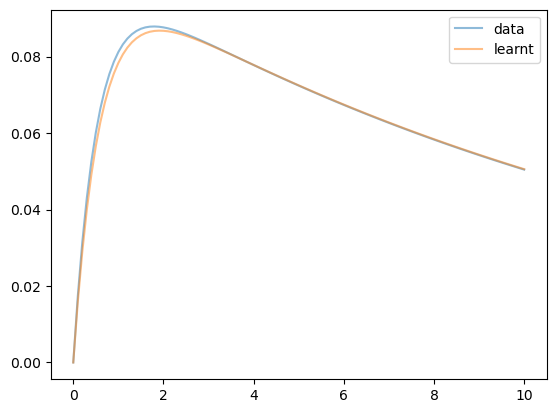

In [27]:
# Define the ODE system
def fitted_RHS(t, A):
    x0, x1 = A  
    dx0 = x0 * -1.7328166
    dx1 = (x0 * 1.7263957) + (x1 * -0.07207295)
    return [dx0, dx1]

# Define time points
T = np.linspace(0, 10, 101)

# Initial conditions
A0 = [0.1, 0]

# Solve ODE
solution = solve_ivp(fitted_RHS, [0, 10], A0, method='RK45', t_eval=T)

A1_fitted, A2_fitted = solution.y

plt.plot(T, A2[0:101], alpha=0.5, label = "data")
plt.plot(T, A2_fitted, alpha=0.5, label = "learnt")
plt.legend()
plt.show()